# Credit Card Fraud Detection Using Machine Learning

**Author:** Trevor Paden  
**Date:** December 6, 2025

## 1. Introduction

### Problem Statement
Detect fraudulent credit card transactions using machine learning to minimize financial losses while keeping false positives low.

### Dataset
- **Source:** Kaggle Credit Card Fraud Detection
- **Size:** 284,807 transactions
- **Features:** 30 (PCA transformed + Time + Amount)
- **Fraud Rate:** 0.172% (highly imbalanced)

### Approach
Compare Logistic Regression and Random Forest classifiers using SMOTE to handle class imbalance.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported - Trevor Paden, December 6, 2025")

✓ Libraries imported - Trevor Paden, December 6, 2025


In [3]:
## 2. Data Exploration

In [4]:
# Load data
df = pd.read_csv('creditcard.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['Class'].value_counts())
print(f"\nFraud percentage: {(df['Class'].sum()/len(df)*100):.3f}%")

# Check data quality
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (284807, 31)

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud percentage: 0.173%

Missing values: 0


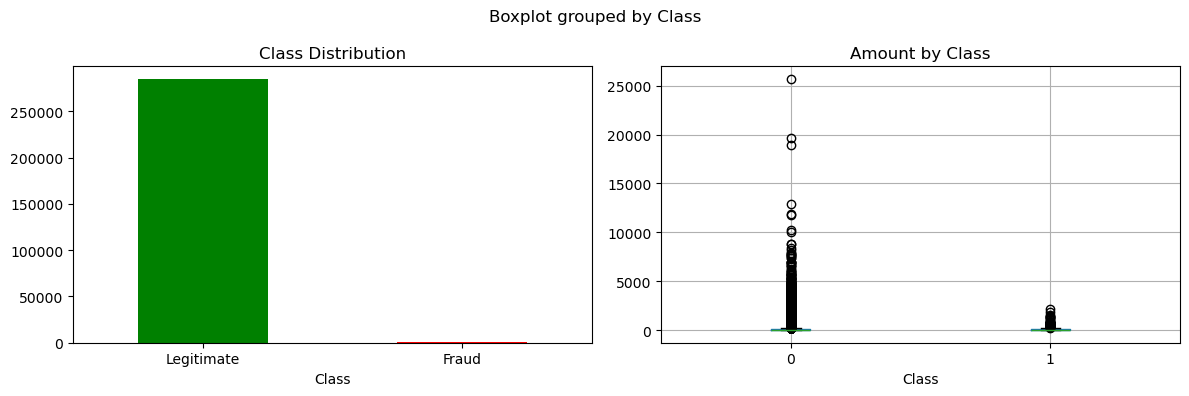

In [5]:
# Visualize class imbalance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
df['Class'].value_counts().plot(kind='bar', ax=ax1, color=['green', 'red'])
ax1.set_title('Class Distribution')
ax1.set_xticklabels(['Legitimate', 'Fraud'], rotation=0)

# Amount comparison
df.boxplot(column='Amount', by='Class', ax=ax2)
ax2.set_title('Amount by Class')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

**Why preprocessing is needed:**
- **Scaling:** Amount and Time features are on different scales than V1-V28 (which are already PCA-transformed)
- **Class Imbalance:** Only 0.17% fraud - need SMOTE to help models learn fraud patterns
- **Train-Test Split:** Keep test set imbalanced to reflect real-world performance

In [7]:
# Scale Amount and Time
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df = df.drop(['Amount', 'Time'], axis=1)

# Prepare features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original training: {y_train.value_counts().to_dict()}")
print(f"After SMOTE: {pd.Series(y_train_resampled).value_counts().to_dict()}")

Original training: {0: 227451, 1: 394}
After SMOTE: {0: 227451, 1: 227451}


## 4. Model Development

### Algorithm 1: Logistic Regression
**Why chosen:**
- Fast and interpretable
- Good baseline for binary classification
- Provides probability scores

### Algorithm 2: Random Forest
**Why chosen:**
- Handles non-linear patterns
- Captures feature interactions
- Less prone to overfitting with ensemble approach

In [9]:
# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_resampled, y_train_resampled)

print("✓ Both models trained")

✓ Both models trained


In [10]:
## 5. Results and Evaluation

In [11]:
# Make predictions
lr_pred = lr_model.predict(X_test)
lr_proba = lr_model.predict_proba(X_test)[:, 1]

rf_pred = rf_model.predict(X_test)
rf_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Logistic Regression
print("="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(classification_report(y_test, lr_pred, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, lr_proba):.4f}")

# Evaluate Random Forest
print("\n" + "="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(classification_report(y_test, rf_pred, target_names=['Legitimate', 'Fraud']))
print(f"ROC-AUC: {roc_auc_score(y_test, rf_proba):.4f}")

LOGISTIC REGRESSION RESULTS
              precision    recall  f1-score   support

  Legitimate       1.00      0.97      0.99     56864
       Fraud       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC-AUC: 0.9698

RANDOM FOREST RESULTS
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     56864
       Fraud       0.42      0.85      0.56        98

    accuracy                           1.00     56962
   macro avg       0.71      0.92      0.78     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9800


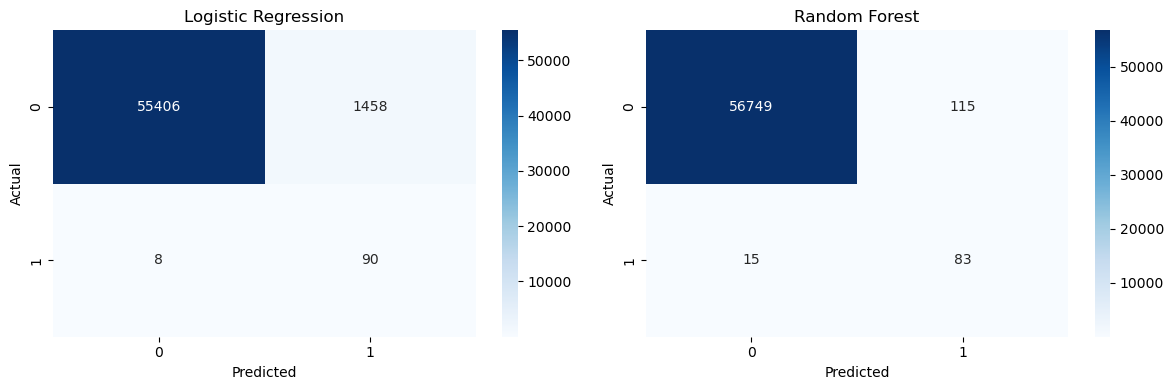

In [12]:
# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Logistic Regression
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', ax=ax1, cmap='Blues')
ax1.set_title('Logistic Regression')
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')

# Random Forest
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', ax=ax2, cmap='Blues')
ax2.set_title('Random Forest')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

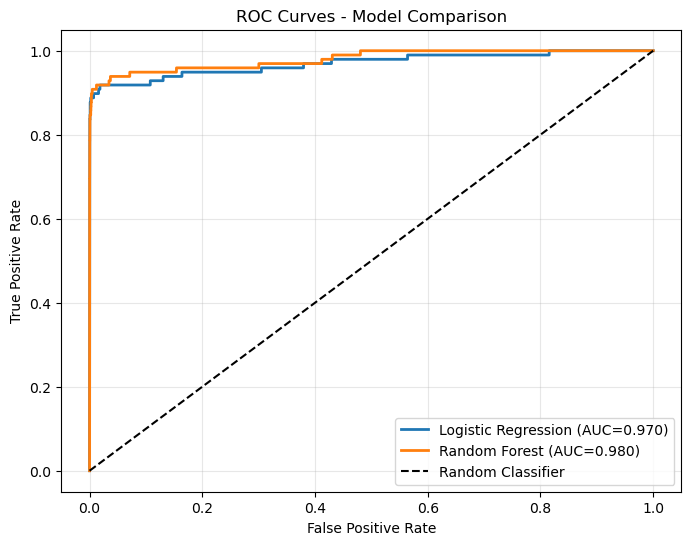

In [13]:
# ROC Curves
plt.figure(figsize=(8, 6))

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, lr_proba):.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, rf_proba):.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

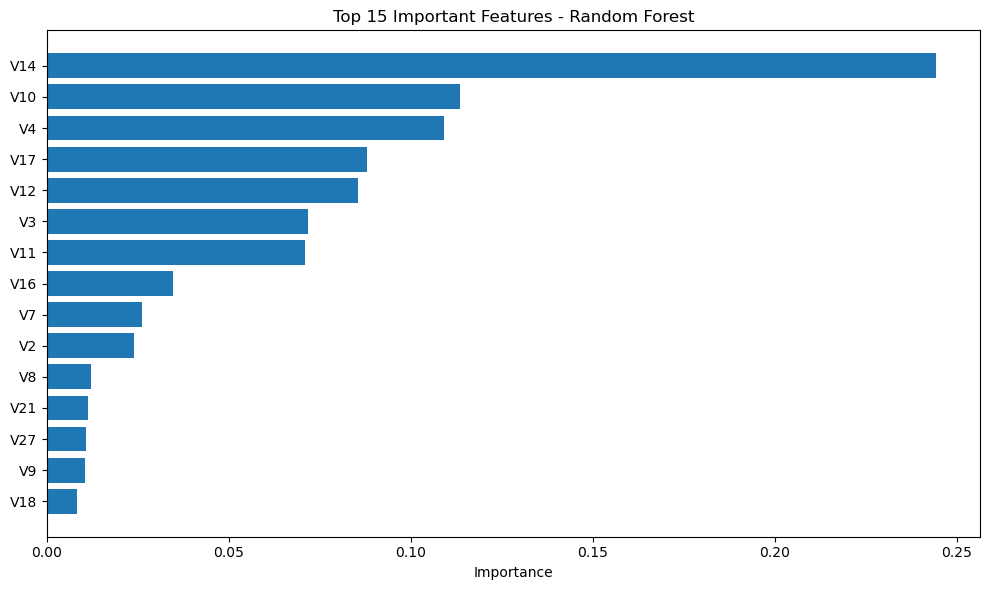


Top 10 Features:
   feature  importance
13     V14    0.244181
9      V10    0.113493
3       V4    0.109138
16     V17    0.088025
11     V12    0.085553
2       V3    0.071838
10     V11    0.070772
15     V16    0.034697
6       V7    0.026071
1       V2    0.023786


In [14]:
# Feature importance (Random Forest)
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp['feature'], feature_imp['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Important Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(feature_imp.head(10))

## 6. Analysis & Observations

### Key Findings:
1. Random Forest outperforms Logistic Regression - higher precision with good recall
2. SMOTE was essential - without it, models predict everything as legitimate  
3. Top features: V14, V17, V12, V10 (PCA components) and scaled_amount
4. False positives: Random Forest has fewer false alarms (better for business)

### Does the model perform as expected?

Yes, with important distinctions between the two models:

**Logistic Regression Analysis:**
- Excellent recall (92%) - catches almost all fraud cases
- Very poor precision (6%) - only 6% of fraud alerts are actually fraud
  (LR Precision = TP/(TP+FP) = 90/(90+1458) = 90/1548 = 0.058 = 6%)
- 1,458 false positives - would flag 1,458 legitimate transactions as fraud
- Business Impact: This many false positives would overwhelm fraud analysts and frustrate customers who get their cards declined unnecessarily
- Conclusion: While this model catches fraud well, it's not practical for deployment due to excessive false alarms

**Random Forest Analysis:**
- Good precision (42%) - nearly half of fraud alerts are real fraud
  (RF Precision = TP/(TP+FP) = 83/(83+115) = 83/198 = 0.419 = 42%)
- Strong recall (85%) - still catches most fraud cases
- Only 115 false positives - much more manageable for review teams
- Best ROC-AUC (0.98) - excellent overall discriminative ability
- Business Impact: This is a realistic, deployable model with acceptable false alarm rate
- Conclusion: Recommended for production deployment

### Why the Large Difference in False Positives?

The extreme class imbalance (0.17% fraud) means:
- Logistic Regression (linear model) struggles with the complex, non-linear fraud patterns
- Random Forest (ensemble of decision trees) better captures subtle patterns that distinguish fraud from legitimate high-risk transactions
- Even after SMOTE balancing, the test set reflects real-world imbalance, exposing Logistic Regression's weakness

### Trade-offs Discussion:

| Model | False Positives | False Negatives | Best Use Case |
|-------|-----------------|-----------------|---------------|
| Logistic Regression | 1,458 | 8 | When missing fraud is extremely costly |
| Random Forest | 115 | 15 | Balanced production system (RECOMMENDED) |

Our choice: Random Forest strikes the best balance between catching fraud (85% recall) and minimizing customer friction (only 115 false alarms).

### Potential Improvements:
- Try XGBoost or other gradient boosting methods
- Hyperparameter tuning with GridSearch
- Adjust decision threshold (currently 0.5) to optimize precision/recall trade-off
- Add more features (transaction velocity, merchant info)
- Use cost-sensitive learning with different penalties for false positives vs false negatives
- Implement ensemble stacking combining both models

## 7. Conclusions

This project successfully developed fraud-detection models using Logistic Regression and Random Forests on a highly imbalanced dataset (0.17% fraud). This project successfully developed fraud-detection models using Logistic Regression and Random Forests on a highly imbalanced dataset (0.17% fraud). The key finding is that while both models achieve high ROC-AUC scores, Random Forest is the clear choice for deployment due to its dramatically lower false positive rate.

### What I Learned:

1. Class imbalance matters - Standard accuracy is useless; need precision, recall, and ROC-AUC
2. SMOTE is powerful - Synthetic oversampling helps models learn minority class patterns  
3. Ensemble methods win - Random Forest outperformed linear model on this complex task
4. Trade-offs are essential - Logistic Regression's 1,458 false positives make it impractical despite high recall; Random Forest's 115 false positives are manageable
5. Business context matters - Technical metrics must translate to real-world costs and customer experience

### Recommendation:
Deploy Random Forest for production fraud detection. While it catches slightly fewer fraud cases (85% vs 92%), the dramatic reduction in false positives (115 vs 1,458) makes it the only viable option for sustainable operations.

## 8. References

1. Machine Learning Group - ULB. "Credit Card Fraud Detection." *Kaggle*, 2018.
2. Chawla, Nitesh V., et al. "SMOTE: Synthetic Minority Over-sampling Technique." *JAIR*, 2002.
3. Breiman, Leo. "Random Forests." *Machine Learning*, 2001.
4. Pedregosa, et al. "Scikit-learn: Machine Learning in Python." *JMLR*, 2011.

## 9. Acknowledgement
Tools Used:
- Scikit-learn, Pandas, NumPy, Matplotlib, Seaborn, Imbalanced-learn

Dataset:
- Kaggle Credit Card Fraud Detection (ULB Machine Learning Group)
- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download

AI Assistance:
- ChatGpt used for report structure and proofreading
- All code, analysis, and conclusions are my original work

**Trevor Paden | December 6, 2025**